In [1]:
import fenics as fn
import numpy as np
#
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

PDE Problem:

$$
\left\{
\begin{array}{rlc}
\varepsilon u_x(x,y) + u(x,y) &= f(x,y) & \text{ in }(0,1)\times(0,1) \\
u(0,y) &= 0 & 
\end{array}
\right.
$$

**Mesh**

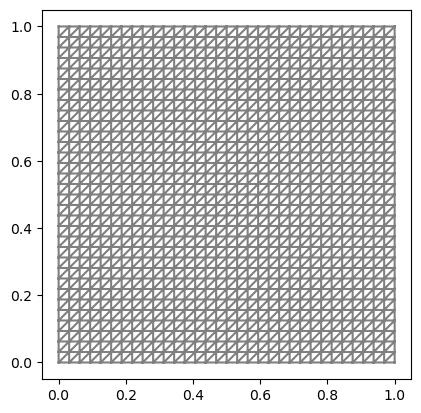

In [2]:
N = 32
mesh = fn.UnitSquareMesh(N,N)
fn.plot(mesh)
plt.show()

**FE space**

In [3]:
Uh = fn.FunctionSpace(mesh,'CG',1)

**Trial and test functions**

In [4]:
uh = fn.TrialFunction(Uh)
vh = fn.TestFunction(Uh)

Variational formulation:
$$\int_{\Omega} (\varepsilon u_x + u) (\varepsilon v_x + v) = \int_{\Omega} f (\varepsilon v_x + v), \quad\forall v \in H^{1}$$

In [5]:
#
def biliniear_form_func(u,v,eps=0.001):
    aux = (eps*u.dx(0) + u)*(eps*v.dx(0) + v)*(fn.dx)
    return aux
# 
def rhs_func(f,v,eps=0.001):
    aux = f*(eps*v.dx(0) + v)*(fn.dx)
    return aux

**Rhs function**

In [6]:
#f = fn.Constant(1.)
f = fn.Expression('x[1]< 0.5 ? 1.: 0.',degree=0)
#f = fn.Expression('sin(pi*x[0])',pi=np.pi,degree=0)

**Boundary Condition**

In [7]:
# Boundary condition
g = fn.Constant(0.)
bc_gamma = fn.DirichletBC(Uh,g,'x[0]<DOLFIN_EPS')

**Assembling**

In [8]:
eps = .05
b = biliniear_form_func(uh,vh,eps)
l = rhs_func(f,vh,eps)
# Linear system
B, L = fn.assemble_system(b,l,bc_gamma)

**Linear system as numpy array**

In [9]:
B_np = B.array()
L_np = L[:]

**Solving the linear system**

In [10]:
vec = np.linalg.solve(B_np,L_np)
uh_sol = fn.Function(Uh)
uh_sol.vector()[:] = vec

**Results**

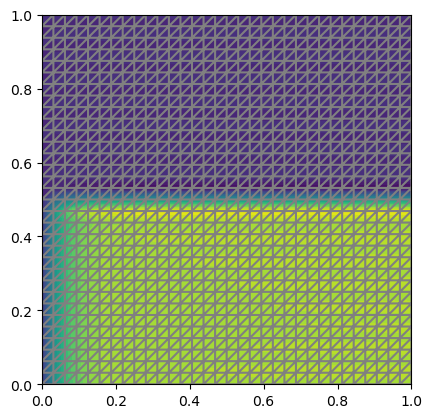

In [11]:
fn.plot(uh_sol)
fn.plot(mesh)
plt.show()

In [12]:
X,Y = np.meshgrid(np.linspace(0,1,2*N+1),np.linspace(0,1,2*N+1))
U   = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        U[i,j] = uh_sol(X[i,j],Y[i,j])

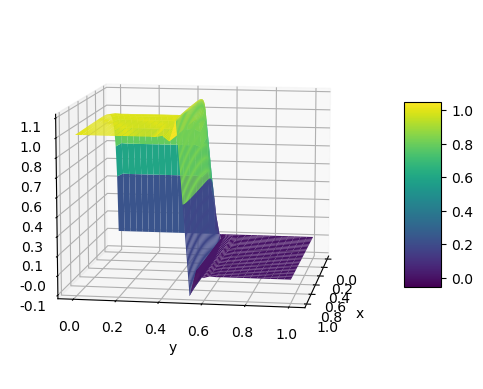

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, U, cmap=cm.viridis,
                       linewidth=0.1, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.01f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
#
ax.view_init(elev=10., azim=9.)

plt.show()

##  $L_1$ regularization term

In [14]:
Dh = fn.FunctionSpace(mesh,'DG',0)
dh = fn.TestFunction(Dh)

**$D_x$ matrix**

In [15]:
D1 = fn.assemble(uh.dx(0)*dh*(fn.dx))
#print(D1.array())

**$D_y$ matrix**

In [16]:
D2 = fn.assemble(uh.dx(1)*dh*(fn.dx))
#print(D2.array())

**Exporting matrices**

In [17]:
np.savez('2D_LSQ_matrices',B=B_np,L=L_np,Dx=D1.array(),Dy=D2.array())